In [1]:
import os, sys
sys.path.append('../src/')

from copulae1 import *

import json
with open('../src/configs/config_coingecko_future_v3_MM.json','r') as file:
    config = json.load(file)
config
data_name = config['data_name']
calibration_method  = config['calibration_method']
OHR = pd.read_hdf('../results/'+data_name +'/'+calibration_method+'/best_h.h5')
if not os.path.exists("../results/" + data_name + "/MLE/reports"):
	print("Create new folder for results")
	os.mkdir("../results/" + data_name + "/MLE/reports")
	os.mkdir("../results/" + data_name + "/MM/reports")
    
if calibration_method == "MLE":
    report_path = "../results/" + data_name + "/MLE/reports/"
    result_path = "../results/" + data_name + "/MLE/"
elif calibration_method == "MM":
    report_path = "../results/" + data_name + "/MM/reports/"
    result_path = "../results/" + data_name + "/MM/"
    
data_path = "../processed_data/"+data_name+'/test/'

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
natp_path = '../_mathematica/data/'
natp_ls = os.listdir(natp_path)
natp_h = [l for l in natp_ls if l.endswith('_h.csv')]
file_names = [l.replace('_h','') for l in natp_h]
OHR_combined = []
for i in range(len(natp_h)):
    print(i)
    _natp_h = pd.DataFrame(open(natp_path+natp_h[i], 'r').readlines())
    _natp_h = _natp_h.iloc[1:7,:]
    file_name = natp_h[i].replace('_h','')
    for i in range(len(_natp_h)):
        _natp_h.iloc[i,0] = np.float32(_natp_h.iloc[i,0].replace('\n',''))
    _natp_h.columns = ['NIG_factor']
    _natp_h.index = ['Variance', 'VaR q=0.01', 'VaR q=0.05', 'ES q=0.01', 'ES q=0.05', 'ERM k=10']
    _natp_h = _natp_h.T
    
    OHR_combined.append(OHR.loc[:,file_name].append(_natp_h))
OHR = pd.concat(OHR_combined, axis=1, keys=file_names).dropna(axis=1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


In [3]:
Copula_names = ['Gaussian', 't_Copula', 'Clayton', 'Frank', 'Gumbel', 'Plackett', 'Gauss Mix Indep', 'NIG_factor']
# Copula_names = ['Gaussian', 't_Copula', 'Clayton', 'Frank', 'Gumbel', 'Plackett', 'Gauss Mix Indep']

OHR = OHR.loc[Copula_names,:]

In [4]:
temp = []
for C in Copula_names:
    hs_by_Copula = OHR.loc[C:C,:].melt()
    hs_by_Copula.columns = ['file_name', 'risk_measure', 'OHR']
    hs_by_Copula.loc[:, 'copula'] = C
    temp.append(hs_by_Copula)

OHR_to_math = pd.concat(temp, axis=0)

In [5]:
files = np.unique(OHR_to_math.file_name)
risk_measures = np.unique(OHR_to_math.risk_measure)

In [6]:
# C = Copula_names[0]
results = {}

for C in Copula_names:
    for rm in risk_measures:
        id_C = OHR_to_math.copula == C
        id_rm = OHR_to_math.risk_measure == rm


        df = OHR_to_math.loc[id_C&id_rm, :]
        df.reset_index(inplace=True, drop=True)

        rh_arr = []
        rs_arr = []
        rf_arr = []

        Date_arr = []

        for i in range(len(df)):
            h = df.iloc[i,:].OHR
            test = pd.read_csv(data_path+df.iloc[i,:].file_name)
            Date = test.Date
            rs = test.loc[:, 'log return bitcoin']
            rf = test.loc[:, 'log return future']
            rh = rs - h*rf
            rh_arr.append(rh)
            Date_arr.append(Date)

            rs_arr.append(rs)
            rf_arr.append(rf)
            
        rh_df = pd.DataFrame({'Date':np.array(Date_arr).reshape((-1)), 'rh':np.array(rh_arr).reshape((-1))})
        rs_df = pd.DataFrame({'Date':np.array(Date_arr).reshape((-1)), 'rs':np.array(rs_arr).reshape((-1))})
        rf_df = pd.DataFrame({'Date':np.array(Date_arr).reshape((-1)), 'rf':np.array(rf_arr).reshape((-1))})
        
        rh_df.Date = pd.to_datetime(rh_df.Date)
        rs_df.Date = pd.to_datetime(rs_df.Date)
        rf_df.Date = pd.to_datetime(rf_df.Date)
        
        # sort Date to make sure the cumulative sum is correct (sort from old data to new data)
        rh_df = rh_df.sort_values('Date', ascending=True).reset_index( drop=True)
        rs_df = rs_df.sort_values('Date', ascending=True).reset_index( drop=True)
        rf_df = rf_df.sort_values('Date', ascending=True).reset_index( drop=True)
      
        rh_df.loc[:,'cumsum'] = np.cumsum(rh_df.rh)
        rs_df.loc[:,'cumsum'] = np.cumsum(rs_df.rs)
        rf_df.loc[:,'cumsum'] = np.cumsum(rf_df.rf)
        
        investment = 1
        income_rh = investment*np.exp(rh_df.loc[:,'cumsum'])
        income_rs = investment*np.exp(rs_df.loc[:,'cumsum'])
        income_rf = investment*np.exp(rf_df.loc[:,'cumsum'])
    
        results[(C, rm)] = income_rh

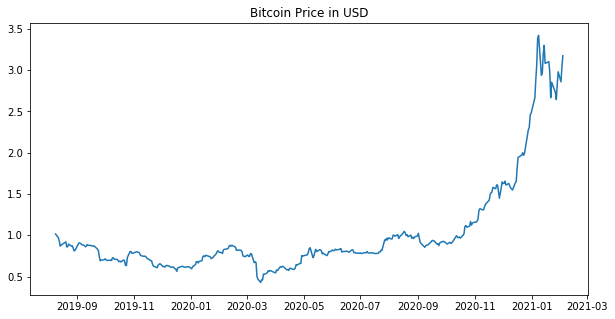

In [9]:
plt.figure(figsize=(10,5))
plt.plot(rh_df.Date, income_rs, label='Long Bitcoin')
plt.title("Bitcoin Price in USD")
plt.savefig('plots/bitcoin_price.png', transparent=True)

In [12]:
rs_df

,Date,rs,cumsum
0,2019-08-09,0.015356,0.015356
1,2019-08-12,-0.045005,-0.029649
2,2019-08-13,-0.044405,-0.074054
3,2019-08-14,-0.066025,-0.140080
4,2019-08-15,0.013129,-0.126951
...,...,...,...
370,2021-01-28,0.067181,1.039722
371,2021-01-29,0.052253,1.091974
372,2021-02-01,-0.041523,1.050452
373,2021-02-02,0.059664,1.110116


In [16]:
rs_df.Date.loc[up_i]

,Date,rs,cumsum
0,2019-08-09,0.015356,0.015356
1,2019-08-12,-0.045005,-0.029649
2,2019-08-13,-0.044405,-0.074054
3,2019-08-14,-0.066025,-0.140080
4,2019-08-15,0.013129,-0.126951
...,...,...,...
370,2021-01-28,0.067181,1.039722
371,2021-01-29,0.052253,1.091974
372,2021-02-01,-0.041523,1.050452
373,2021-02-02,0.059664,1.110116


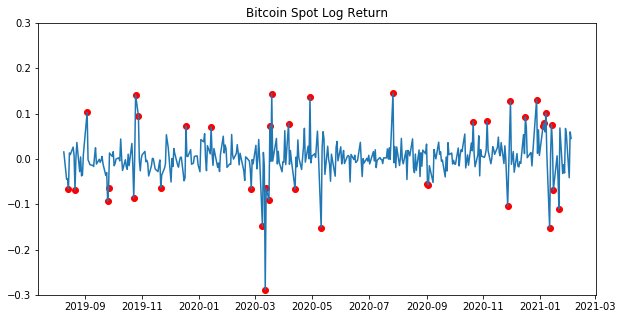

In [44]:
plt.figure(figsize=(10,5))
plt.plot(rs_df.Date, rs_df.rs)

up_i = rs_df.rs > np.quantile(rs_df.rs, 0.95)
plt.scatter(rs_df.Date.loc[up_i], rs_df.rs.loc[up_i], color='r')

low_i = rs_df.rs < np.quantile(rs_df.rs, 0.05)
plt.scatter(rs_df.Date.loc[low_i], rs_df.rs.loc[low_i], color='r')

plt.ylim((-0.3,0.3))


plt.title('Bitcoin Spot Log Return')
plt.savefig('plots/bitcoin_return.png', transparent=True)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


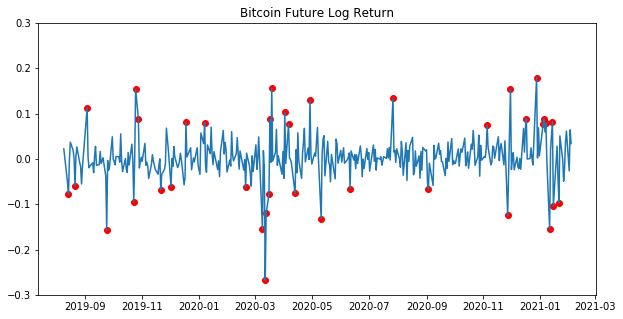

In [45]:
plt.figure(figsize=(10,5))
plt.plot(rf_df.Date, rf_df.rf)

up_i = rf_df.rf > np.quantile(rf_df.rf, 0.95)
plt.scatter(rf_df.Date.loc[up_i], rf_df.rf.loc[up_i], color='r')

low_i = rf_df.rf < np.quantile(rf_df.rf, 0.05)
plt.scatter(rf_df.Date.loc[low_i], rf_df.rf.loc[low_i], color='r')

plt.ylim((-0.3,0.3))

plt.title('Bitcoin Future Log Return')
plt.savefig('plots/future_return.png', transparent=True)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


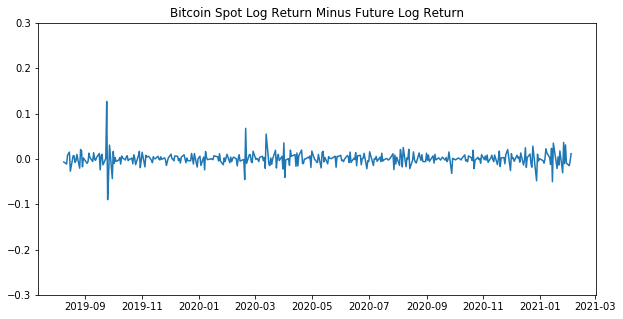

In [46]:
plt.figure(figsize=(10,5))
plt.plot(rf_df.Date, rs_df.rs-rf_df.rf)

plt.ylim((-0.3,0.3))

plt.title('Bitcoin Spot Log Return Minus Future Log Return')
plt.savefig('plots/BTC_minus_future_return.png', transparent=True)

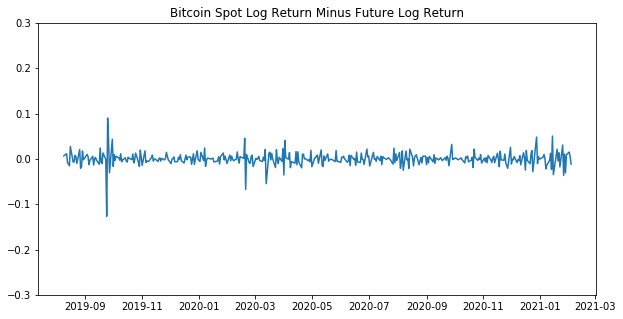

In [48]:
plt.figure(figsize=(10,5))
plt.plot(rf_df.Date, rf_df.rf-rs_df.rs)

plt.ylim((-0.3,0.3))

plt.title('Bitcoin Spot Log Return Minus Future Log Return')
plt.savefig('plots/future_minus_BTC_return.png', transparent=True)

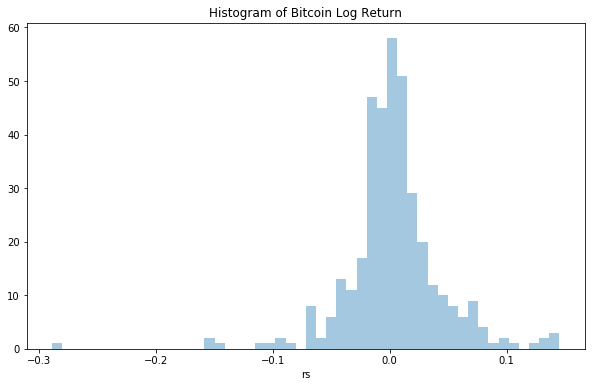

In [53]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.distplot(rs_df.rs, kde=False)
plt.title('Histogram of Bitcoin Log Return')
plt.savefig('plots/Histogram_BTC.png', transparent=True)

Text(0, 0.5, 'Future')

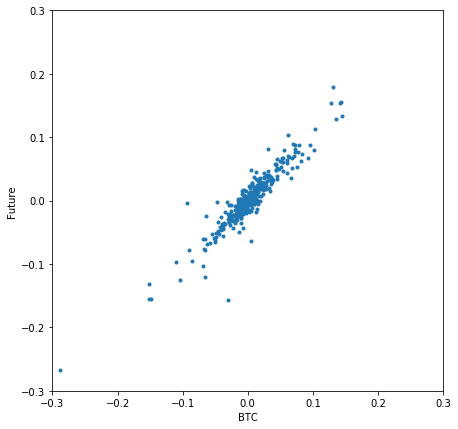

In [63]:
plt.figure(figsize=(7,7))

plt.scatter(rs_df.rs, rf_df.rf, marker='.')
plt.xlim((-0.3,0.3))
plt.ylim((-0.3,0.3))
plt.xlabel("BTC")
plt.ylabel("Future")

In [65]:
u = ECDF(rs_df.rs)(rs_df.rs)
v = ECDF(rf_df.rf)(rf_df.rf)

Text(0, 0.5, 'Future')

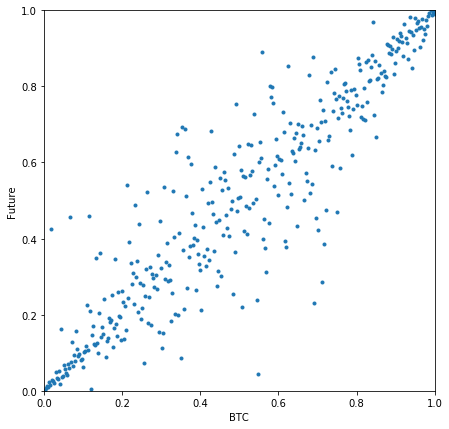

In [67]:
plt.figure(figsize=(7,7))

plt.scatter(u, v, marker='.')
plt.xlim((0,1))
plt.ylim((0,1))
plt.xlabel("BTC")
plt.ylabel("Future")